In [3]:
import sys
sys.path.append('../../')

In [4]:
from scripts.utils import data_path, set_mpl, read_hamelin, add_datetime_features, get_spectrogram
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


%matplotlib inline

set_mpl()

matplotlib settings set


In [5]:
energy, weather, metadata = read_hamelin()



    Loading Hamelin data from /Users/sdbykov/not_work/swarm_energAIser/0_data/.
    Houses number removed: 6, 17, 24, 25. 
    Houses with PV: ['13', '15', '26', '33'] 
    HOUSEHOLD and HEATPUMP energy consumption are separated. 
    Resolution: 60min 

    May-June 2019 data for home #34 excluded 
    Data before 2018-05-18 excluded (gaps)
    Data with zero difference between consecutive values dropped (malfunction)

    reutrns:
    df_energy: pd.DataFrame with energy consumption data
    df_weather: pd.DataFrame with weather data
    df_metadata: pd.DataFrame with metadata

    


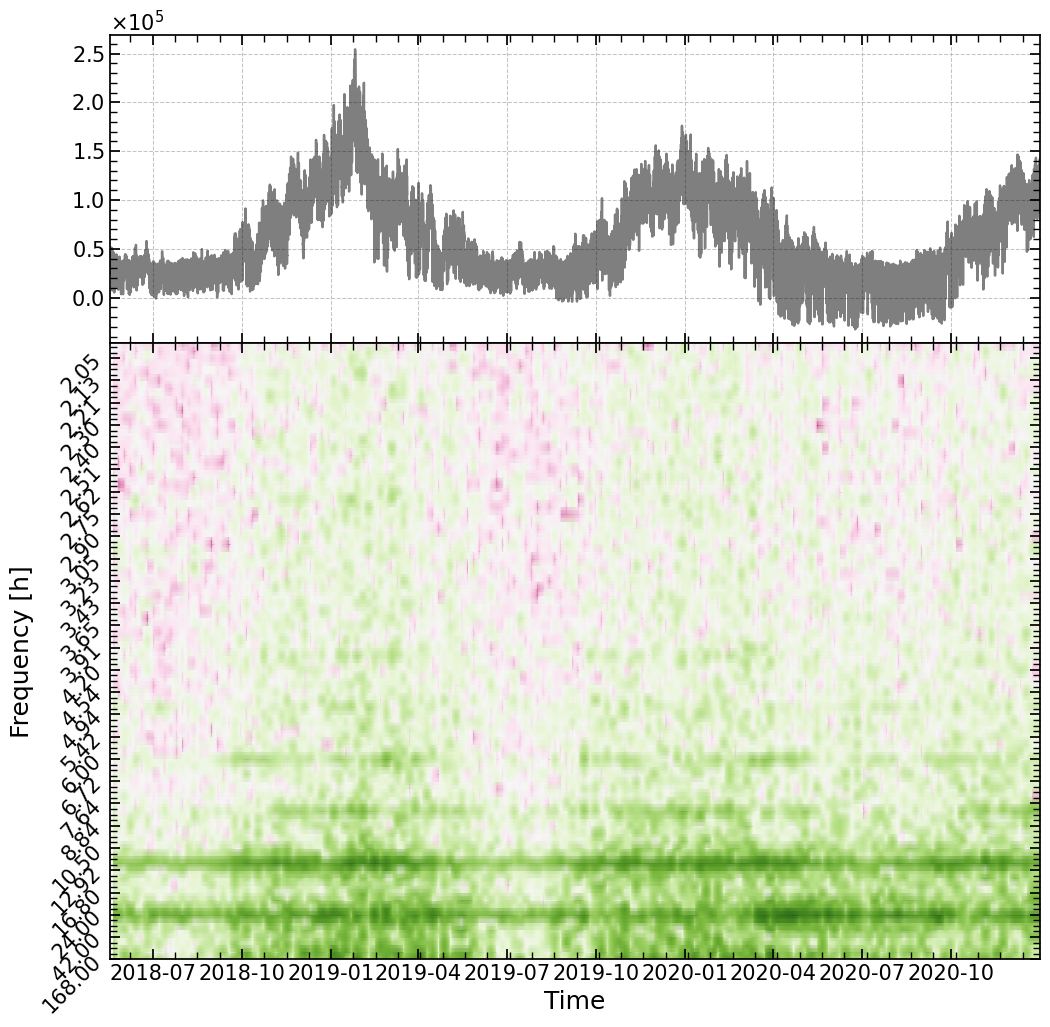

In [6]:
from scipy import signal

power_substation = energy[['P_substation']].fillna(method='ffill')


power_substation_spe = get_spectrogram(power_substation, 'P_substation', 24*7, 24, plot = True)
power_substation_spe = power_substation_spe/np.max(power_substation_spe, axis = 0)

In [7]:
#time series modelling with random forest and covariates

from darts import TimeSeries
from darts.metrics import mape
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr


target = TimeSeries.from_dataframe(power_substation, freq = 'H')

hodidays_covariates = target.add_holidays("DE", state = "NI")['holidays']

frequency_covariates = TimeSeries.from_dataframe(power_substation_spe[['24.00', '12.00', '6.00']], freq = 'H')


temperature_history = weather['WEATHER_T']/np.max(weather['WEATHER_T'])
#perturb temperature to avoid perfect correlation
rolling_std = temperature_history.rolling(24*3).std()
temperature_forecast = temperature_history + np.random.normal(0, rolling_std, size = len(temperature_history))

#temperature_covariate_past = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H')
#temperature_covariate_future  = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H')
temperature_covariate  = TimeSeries.from_dataframe(temperature_forecast.to_frame(), freq = 'H') #we can use it as past and future, although it is not perfect for past predictions


#datetime encodings (normalized)
datetime_covatiates = concatenate(
    [
        dt_attr(time_index = target.time_index, attribute =  "hour", one_hot = False, cyclic = False )/24,
        dt_attr(time_index = target.time_index, attribute =  "day_of_week", one_hot = False, cyclic = False )/7,
        dt_attr(time_index = target.time_index, attribute =  "month", one_hot = False, cyclic = False )/12,
        dt_attr(time_index = target.time_index, attribute =  "day_of_year", one_hot = False, cyclic = False )/365,
    ],
    axis="component",
)

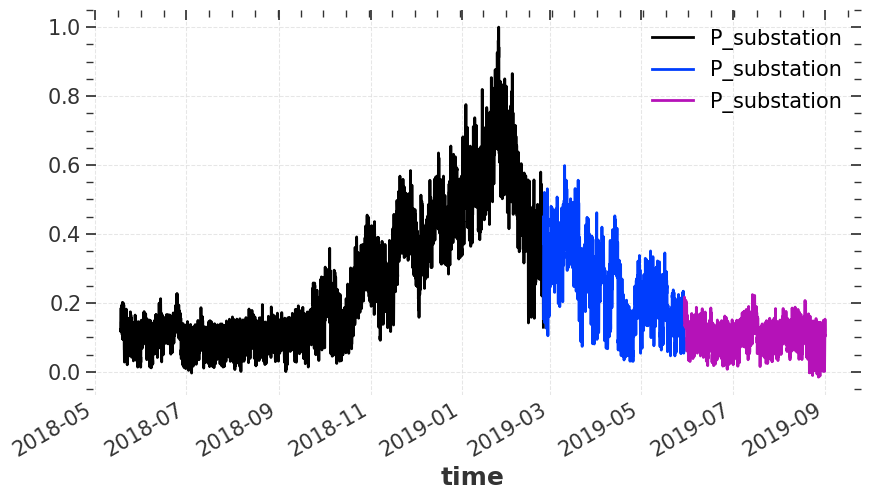

In [8]:
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape, mape, mase

from sklearn.preprocessing import MaxAbsScaler

target, _ = target.split_before(pd.Timestamp('2019-09-01'))
train, val = target.split_before(0.6)
val, test = val.split_before(0.5)

scaler = Scaler(scaler=MaxAbsScaler())
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

val_len = len(val)


fig,  ax =  plt.subplots( figsize = (10,5))

train.plot(ax = ax)
val.plot(ax = ax)
test.plot(ax = ax)



In [45]:
from darts.models import CatBoostModel
from darts.models import RegressionEnsembleModel

lags_horizon = 24


model_naive = val.shift(+24) #repeat value from 24 hours ago
model_naive_train = train.shift(+24) 

model = CatBoostModel(lags_future_covariates=(lags_horizon, lags_horizon), lags_past_covariates=lags_horizon,
                      learning_rate = 0.007, num_trees = 1000, early_stopping_rounds = 5)




cov_args = {"future_covariates": [datetime_covatiates,hodidays_covariates],
        "past_covariates": [frequency_covariates]}

model.fit(train, **cov_args)

models = [model_naive, model]
names = ['naive',  'catboost']

naive mape - train: 21.7857
naive mape - CV: 24.0775
catboost mape - train: 10.9301
catboost mape - CV: 26.6304


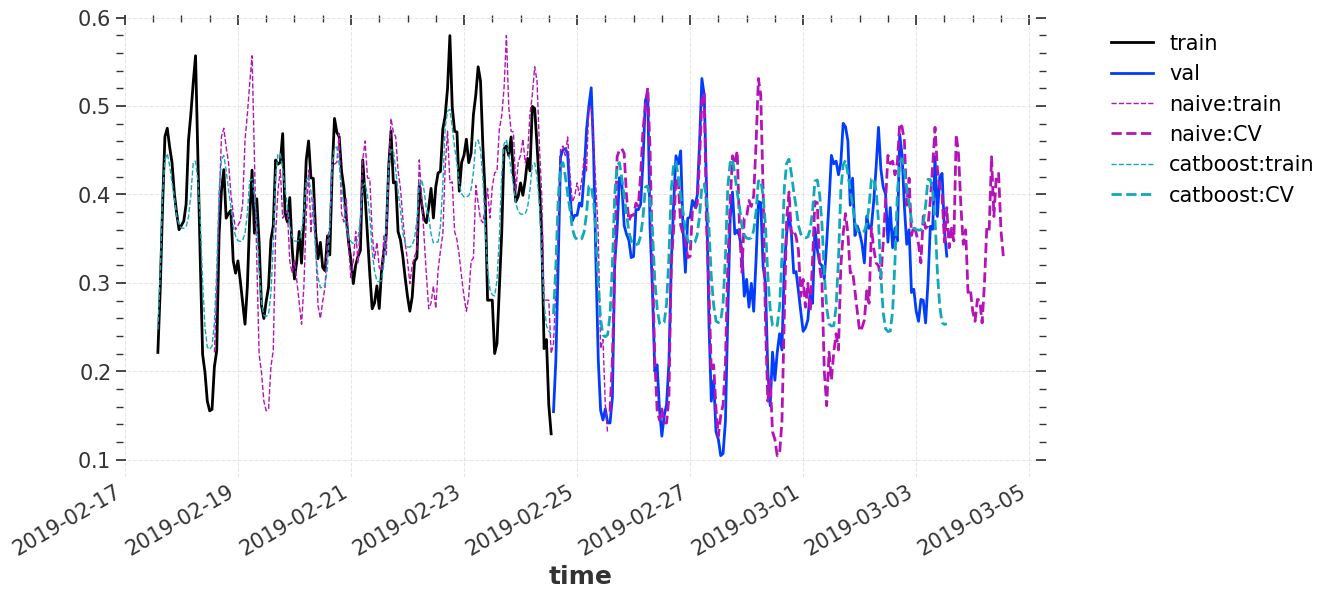

In [46]:
horizon = 24*7*1 #one week ahead


fig,  ax =  plt.subplots( figsize = (12,6))
train.tail(horizon).plot(ax = ax, label = 'train', lw = 2, alpha = 0.2)
val.head(horizon).plot(ax = ax, label = 'val', lw = 2, alpha = 0.2)

for model, name  in zip(models, names):
    if name == 'naive':
        pred_cv = model_naive 
        pred_train = model_naive_train
    else:
        pred_cv = model.predict(horizon)
        pred_train = model.predict(24*7, train[0: -24*7])
    
    
    print(f'{name} mape - train: {mape(train, pred_train):3g}')
    print(f'{name} mape - CV: {mape(val, pred_cv):3g}')
    pred_train.tail(horizon).plot(ax = ax,  ls = '--', lw = 1, alpha = 0.3, label = name+':train')
    color =  ax.get_lines()[-1].get_color()
    pred_cv.head(horizon).plot(ax = ax,  ls = '--', lw = 2, alpha = 0.5, color = color, label = name+':CV')

#put legend outside
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', )
